# Imports

In [1]:
# data
# graphs
import numpy as np
import pandas as pd
import seaborn as sns
# preprocessing
from sklearn.preprocessing import LabelEncoder

# graphic settings
sns.set()

In [2]:
# main table is already split in train/test, so we will apply the same process to both
app_train = pd.read_csv("../data/raw/application_train.csv")
app_test = pd.read_csv("../data/raw/application_test.csv")

# Cleaning

### Fixing Outliers

In [3]:
# Replace Outliers value by imputing NaN and add flag to keep track
# train
app_train["FLAG_ANOMALY_DAYS_EMPLOYED"] = app_train.DAYS_EMPLOYED > 365 * 100
outlier_value = app_train.DAYS_EMPLOYED.max()
app_train.DAYS_EMPLOYED.replace(outlier_value, np.nan, inplace=True)
# test
app_test["FLAG_ANOMALY_DAYS_EMPLOYED"] = app_test.DAYS_EMPLOYED > 365 * 100
outlier_value = app_test.DAYS_EMPLOYED.max()
app_test.DAYS_EMPLOYED.replace(outlier_value, np.nan, inplace=True)

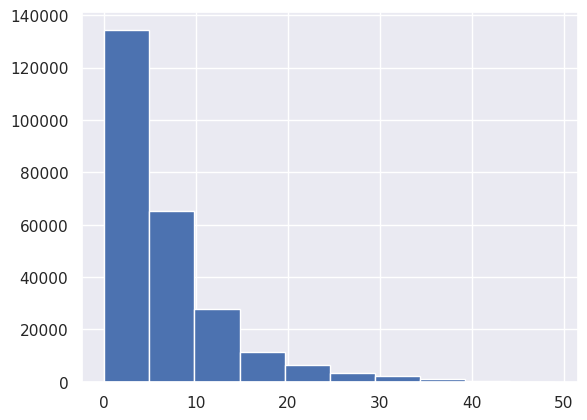

In [4]:
(app_train.DAYS_EMPLOYED / -365).hist();

In [5]:
app_train[(app_train.AMT_INCOME_TOTAL > 1000000)].AMT_INCOME_TOTAL.shape

(250,)

<Axes: >

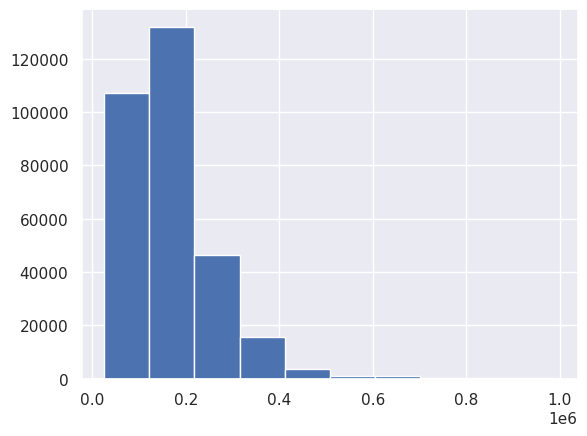

In [6]:
# Print dist of AMT_INCOME_TOTAL without extreme outliers for better visibility
app_train[(app_train.AMT_INCOME_TOTAL < 1000000)].AMT_INCOME_TOTAL.hist()

# Feature engineering

## Label Encoding for categories with 2 labels

In [7]:
# categorical features with only 2 classes are label-encoded
le = LabelEncoder()
for col in app_train:
    if app_train[col].dtype == "object":
        if app_train[col].nunique(dropna=False) <= 2:
            print(col, app_train[col].unique(), "-> ", end="")
            # train
            app_train[col] = le.fit_transform(app_train[col])
            # test
            app_test[col] = le.fit_transform(app_test[col])
            print(app_train[col].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans'] -> [0 1]
FLAG_OWN_CAR ['N' 'Y'] -> [0 1]
FLAG_OWN_REALTY ['Y' 'N'] -> [1 0]


## One-Hot encoding for categories with more than 2 labels

In [8]:
app_train.dtypes.value_counts()

float64    66
int64      43
object     13
bool        1
Name: count, dtype: int64

In [9]:
app_train.select_dtypes("object").nunique(dropna=False)

CODE_GENDER                    3
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64

In [10]:
print(app_train.shape)
app_train = pd.get_dummies(app_train)
print(app_train.shape)

(307511, 123)
(307511, 244)


In [11]:
# same for test
print(app_test.shape)
app_test = pd.get_dummies(app_test)
print(app_test.shape)

(48744, 122)
(48744, 240)


## Realign columns

In [12]:
# some features have different categories in train and test
# => number of columns is different
target = app_train["TARGET"]

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join="inner", axis=1)

# Add the target back in
app_train["TARGET"] = target

print("train :", app_train.shape)
print("test :", app_test.shape)

train : (307511, 241)
test : (48744, 240)


## Financial features using Kaggle Kernel

In [13]:
# from https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
# Some simple new features (percentages)
app_train["FE_DAYS_EMPLOYED_PERC"] = (
    app_train["DAYS_EMPLOYED"] / app_train["DAYS_BIRTH"]
)
app_train["FE_INCOME_CREDIT_PERC"] = (
    app_train["AMT_INCOME_TOTAL"] / app_train["AMT_CREDIT"]
)
app_train["FE_INCOME_PER_PERSON"] = (
    app_train["AMT_INCOME_TOTAL"] / app_train["CNT_FAM_MEMBERS"]
)
app_train["FE_ANNUITY_INCOME_PERC"] = (
    app_train["AMT_ANNUITY"] / app_train["AMT_INCOME_TOTAL"]
)
app_train["FE_PAYMENT_RATE"] = app_train["AMT_ANNUITY"] / app_train["AMT_CREDIT"]

In [14]:
# same for test
app_test["FE_DAYS_EMPLOYED_PERC"] = app_test["DAYS_EMPLOYED"] / app_test["DAYS_BIRTH"]
app_test["FE_INCOME_CREDIT_PERC"] = (
    app_test["AMT_INCOME_TOTAL"] / app_test["AMT_CREDIT"]
)
app_test["FE_INCOME_PER_PERSON"] = (
    app_test["AMT_INCOME_TOTAL"] / app_test["CNT_FAM_MEMBERS"]
)
app_test["FE_ANNUITY_INCOME_PERC"] = (
    app_test["AMT_ANNUITY"] / app_test["AMT_INCOME_TOTAL"]
)
app_test["FE_PAYMENT_RATE"] = app_test["AMT_ANNUITY"] / app_test["AMT_CREDIT"]

# Save transformed data

In [15]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 246 entries, SK_ID_CURR to FE_PAYMENT_RATE
dtypes: bool(132), float64(71), int64(43)
memory usage: 306.2 MB


In [16]:
# save using pickle to keep exact dtypes (csv will result in bigger files and higher memory footprint)
app_train.to_pickle("../data/processed/app_train_cleaned.pkl")
app_test.to_pickle("../data/processed/app_test_cleaned.pkl")
app_train.sample(frac=0.01).to_pickle("../data/processed/app_train_cleaned_sample.pkl")